<a href="https://colab.research.google.com/github/prtk0007/Pneumonia-Covid19-detection/blob/main/Binary_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
# # !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images
!unzip \*.zip

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
#from keras.applications.resnet50 import ResNet50
#from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
incept3=InceptionV3(input_shape=(180,180,3),
                             include_top=False,
                             weights='imagenet')
#freazing the trained layers
for layers in incept3.layers:
    layers.trainable=False

In [ ]:
last_layer=incept3.get_layer('mixed10')
last_output = last_layer.output

In [ ]:
from keras.layers import Dropout
x=Flatten()(last_output)
x=Dense(1024,activation='relu')(x)
x=Dropout(0.4)(x)
x=Dense(256,activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(1,activation='sigmoid')(x)

model3=Model(incept3.input,x)
from keras.optimizers import Adam
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
               metrics=['accuracy'])
# model4.summary()

In [ ]:
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 89, 89, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 89, 89, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 89, 89, 32)   0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   rotation_range = 20,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255) 
val_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('/content/train',
                                                 target_size = (180, 180),
                                                 batch_size = 64,
                                                 class_mode = 'binary')

Found 4192 images belonging to 2 classes.


In [ ]:
test_set = test_datagen.flow_from_directory('/content/test',
                                            target_size = (180, 180),
                                            batch_size = 64,
                                            shuffle=False,
                                            class_mode = 'binary')

val_set = test_datagen.flow_from_directory('/content/val',
                                            target_size = (180, 180),
                                            batch_size = 64,
                                            shuffle=False,
                                            class_mode = 'binary')

Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
early = EarlyStopping(monitor='val_loss', mode='min', patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience =  4 , verbose=1,factor=0.01, min_lr=0.0001)
callbacks_list = [ early, learning_rate_reduction]

In [ ]:
r3=model3.fit(training_set,validation_data=val_set,epochs=25,verbose=2,callbacks=callbacks_list)

Epoch 1/25
66/66 - 78s - loss: 4.6538 - accuracy: 0.7956 - val_loss: 0.9982 - val_accuracy: 0.6625
Epoch 2/25
66/66 - 72s - loss: 0.5145 - accuracy: 0.8714 - val_loss: 0.2491 - val_accuracy: 0.9154
Epoch 3/25
66/66 - 72s - loss: 0.3016 - accuracy: 0.8924 - val_loss: 0.2089 - val_accuracy: 0.9471
Epoch 4/25
66/66 - 72s - loss: 0.2437 - accuracy: 0.9148 - val_loss: 0.1988 - val_accuracy: 0.9298
Epoch 5/25
66/66 - 71s - loss: 0.2214 - accuracy: 0.9151 - val_loss: 0.1829 - val_accuracy: 0.9337
Epoch 6/25
66/66 - 71s - loss: 0.2193 - accuracy: 0.9175 - val_loss: 0.1950 - val_accuracy: 0.9308
Epoch 7/25
66/66 - 71s - loss: 0.2214 - accuracy: 0.9179 - val_loss: 0.1789 - val_accuracy: 0.9471
Epoch 8/25
66/66 - 72s - loss: 0.2050 - accuracy: 0.9194 - val_loss: 0.1417 - val_accuracy: 0.9519
Epoch 9/25
66/66 - 71s - loss: 0.1829 - accuracy: 0.9344 - val_loss: 0.1421 - val_accuracy: 0.9510
Epoch 10/25
66/66 - 71s - loss: 0.1730 - accuracy: 0.9339 - val_loss: 0.1544 - val_accuracy: 0.9452
Epoch 11/

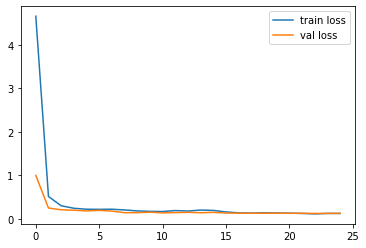

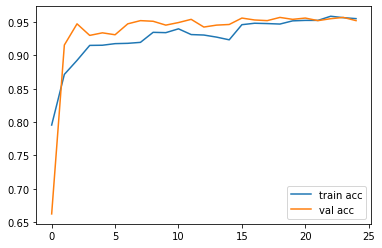

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(r3.history['loss'], label='train loss')
plt.plot(r3.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r3.history['accuracy'], label='train acc')
plt.plot(r3.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
model3.evaluate(test_set)

10/10 [==============================] - 5s 448ms/step - loss: 0.3227 - accuracy: 0.9038


[0.32272154092788696, 0.9038461446762085]

In [ ]:
preds = model3.predict(test_set,verbose=1)

10/10 [==============================] - 6s 474ms/step


In [ ]:
predictions = preds.copy()
predictions[predictions <= 0.75] = 0
predictions[predictions > 0.75] = 1

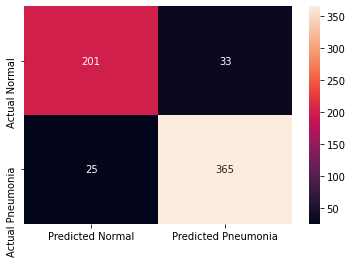

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

cm = pd.DataFrame(data=confusion_matrix(test_set.classes, predictions, labels=[0, 1]),
                  index=["Actual Normal", "Actual Pneumonia"],
                  columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
 print(classification_report(y_true=test_set.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']
 ))

              precision    recall  f1-score   support

      NORMAL       0.89      0.86      0.87       234
   PNEUMONIA       0.92      0.94      0.93       390

    accuracy                           0.91       624
   macro avg       0.90      0.90      0.90       624
weighted avg       0.91      0.91      0.91       624



In [ ]:
cd /content/drive/MyDrive/Kaggle

/content/drive/MyDrive/Kaggle


chest_xray		  drive		    kaggle.json
chest-xray-pneumonia.zip  Inceptv3_xray.h5  sample_data


In [ ]:
model3.save('Inceptv3_xray_acc91_f187.h5')

In [ ]:
from keras.models import load_model